<a href="https://colab.research.google.com/github/Kolibri25/WINDIFY_AI/blob/main/IPAD_DataAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Get to the right working directory

In [18]:
import os
os.getcwd()

'/content/drive/MyDrive/ColabNotebooks/MetFutII-DataChange/BARRA_C2'

In [19]:
os.chdir('/content/drive/MyDrive/ColabNotebooks/MetFutII-DataChange/BARRA_C2')
os.listdir()

['uas_gesamt.nc', 'vas_gesamt.nc']

einlesen der Datein

In [20]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew

In [21]:
dB_vas = xr.open_dataset("/content/drive/MyDrive/ColabNotebooks/MetFutII-DataChange/BARRA_C2/vas_gesamt.nc")
dB_uas = xr.open_dataset("/content/drive/MyDrive/ColabNotebooks/MetFutII-DataChange/BARRA_C2/uas_gesamt.nc")
dE = xr.open_dataset("/content/drive/MyDrive/ColabNotebooks/MetFutII-DataChange/ERA5/ERA5_extracted_nc/ERA5/combined_era5.nc")

In [23]:
dE

<xarray.Dataset> Size: 484MB
Dimensions:     (latitude: 41, longitude: 109, valid_time: 5415)
Coordinates:
  * latitude    (latitude) float64 328B -43.0 -42.75 -42.5 ... -33.25 -33.0
  * longitude   (longitude) float64 872B 126.0 126.2 126.5 ... 152.5 152.8 153.0
  * valid_time  (valid_time) datetime64[ns] 43kB 1979-01-01 ... 2024-12-31
    number      int64 8B ...
Data variables:
    t2m         (valid_time, latitude, longitude) float32 97MB ...
    msl         (valid_time, latitude, longitude) float32 97MB ...
    mwd         (valid_time, latitude, longitude) float32 97MB ...
    u10         (valid_time, latitude, longitude) float32 97MB ...
    v10         (valid_time, latitude, longitude) float32 97MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-05-21T09:30 GRIB to CDM+CF via cfgrib-0.9.1...

# Find the Missing Years

In [22]:
import numpy as np
import pandas as pd

# Dein dE-Array, z. B. als NumPy-Array
# Beispiel: dE = np.array([...], dtype='datetime64[ns]')

# 1. In Pandas Series umwandeln und sicherstellen, dass es datetime ist
dates = pd.Series(dE.valid_time)
dates = pd.to_datetime(dates)  # ← wichtig!

# 2. Alle eindeutigen Monate extrahieren, z. B. "1979-01", "1979-02" etc.
years_in_data = dates.dt.to_period("Y").unique()

# 3. Vollständige Liste aller Monate im erwarteten Bereich erstellen
all_years = pd.period_range(start="1979", end="2024", freq="Y")

# 4. Fehlende Monate finden
missing_years = all_years.difference(years_in_data)

# Ausgabe
print(f"Es fehlen {len(missing_years)} Jahre:")
print(missing_years)

Es fehlen 3 Jahre:
PeriodIndex(['2001', '2004', '2005'], dtype='period[Y-DEC]')


# Skewedness

In [ ]:
vas = dB_vas['vas']
uas = dB_uas['uas']
dE_v10 = dE['v10']
dE_u10 =dE['u10']

In [ ]:
# Flatten und NaNs entfernen
vas_flat = vas.values.flatten()
vas_flat = vas_flat[~np.isnan(vas_flat)]


v10_flat = dE_v10.values.flatten()
v10_flat = v10_flat[~np.isnan(v10_flat)]

In [ ]:
uas_flat = uas.values.flatten()
uas_flat = uas_flat[~np.isnan(uas_flat)]

u10_flat = dE_u10.values.flatten()
u10_flat = u10_flat[~np.isnan(u10_flat)]

In [ ]:
# skewedness berechnen
skew_vas = skew(vas_flat)
print(f"Skewness VAS (BARRA): {skew_vas:.3f}")


Skewness VAS (BARRA): -0.062


In [ ]:
# Stichprobe aus den Daten (weniger RAM um absturz zu verhindern)
uas_sample = dB_uas.uas.isel(time=slice(0, None, 10), lat=slice(0, None, 5), lon=slice(0, None, 5))
uas_flat_sample = uas_sample.values.flatten()

skew_uas = skew(uas_flat_sample, nan_policy='omit')
print(f"Skewness UAS (BARRA) sample: {skew_uas:.3f}")


Skewness UAS (BARRA) sample: 0.473


In [ ]:
skew_v10 = skew(v10_flat)

print(f"Skewness V10 (ERA5):  {skew_v10:.3f}")


Skewness V10 (ERA5):  0.056


In [ ]:
skew_u10 = skew(u10_flat)
print(f"Skewness U10 (ERA5):  {skew_u10:.3f}")


Skewness U10 (ERA5):  0.571


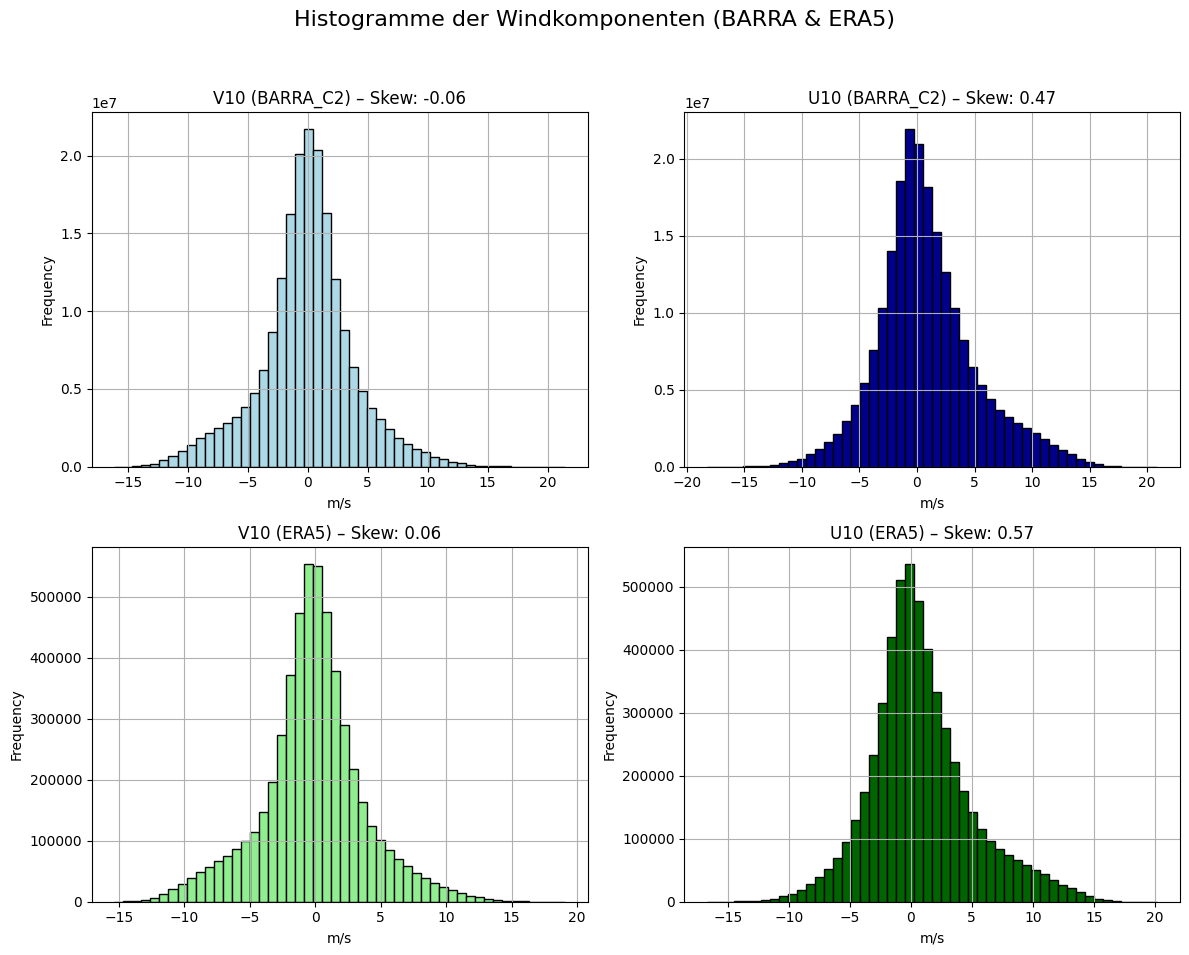

In [ ]:
colors = {
    'vas': '#ADD8E6',   # Hellblau
    'uas': '#00008B',   # Dunkelblau
    'v10': '#90EE90',   # Hellgrün
    'u10': '#006400'    # Dunkelgrün
}

fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Histogramme der Windkomponenten (BARRA & ERA5)", fontsize=16)

# VAS
axs[0, 0].hist(vas_flat, bins=50, color=colors['vas'], edgecolor='black')
axs[0, 0].set_title(f"V10 (BARRA_C2) – Skew: {skew_vas:.2f}")
axs[0, 0].set_xlabel("m/s")
axs[0, 0].set_ylabel("Frequency")
axs[0, 0].grid(True)

# UAS
axs[0, 1].hist(uas_flat, bins=50, color=colors['uas'], edgecolor='black')
axs[0, 1].set_title(f"U10 (BARRA_C2) – Skew: {skew_uas:.2f}")
axs[0, 1].set_xlabel("m/s")
axs[0, 1].set_ylabel("Frequency")
axs[0, 1].grid(True)

# V10
axs[1, 0].hist(v10_flat, bins=50, color=colors['v10'], edgecolor='black')
axs[1, 0].set_title(f"V10 (ERA5) – Skew: {skew_v10:.2f}")
axs[1, 0].set_xlabel("m/s")
axs[1, 0].set_ylabel("Frequency")
axs[1, 0].grid(True)

# U10
axs[1, 1].hist(u10_flat, bins=50, color=colors['u10'], edgecolor='black')
axs[1, 1].set_title(f"U10 (ERA5) – Skew: {skew_u10:.2f}")
axs[1, 1].set_xlabel("m/s")
axs[1, 1].set_ylabel("Frequency")
axs[1, 1].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# Adjust dataset to be devidible by 16

In [ ]:
# theory before praxis
multiples_of_16 = [16 * i for i in range(1, 14)]  # bis 16*13=208
print(multiples_of_16)

[16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192, 208]


In [ ]:
dE_subset = dE.sel(latitude=slice(-43, -35.25), longitude=slice(144.25, 152))
#print(dE_subset.latitude)
print("lat=", len(dE_subset.latitude),"lon=", len(dE_subset.longitude) )

lat= 32 lon= 32


In [ ]:
dB_uas_subset = dB_uas.sel(lat=slice(-43, -35.3), lon=slice(146.25, 152))
#print(dB_uas_subset.lat, dB_uas_subset.lon)
print("lat=", len(dB_uas_subset.lat),"lon=", len(dB_uas_subset.lon) )

lat= 192 lon= 144


In [ ]:
dB_vas_subset = dB_vas.sel(lat=slice(-43, -35.13), lon=slice(144.25, 152))
#print(dB_vas_subset.lat, dB_vas_subset.lon)
print("lat=", len(dB_vas_subset.lat),"lon=", len(dB_vas_subset.lon) )

lat= 192 lon= 144


# plotting on a map

In [ ]:
!pip install cartopy

In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

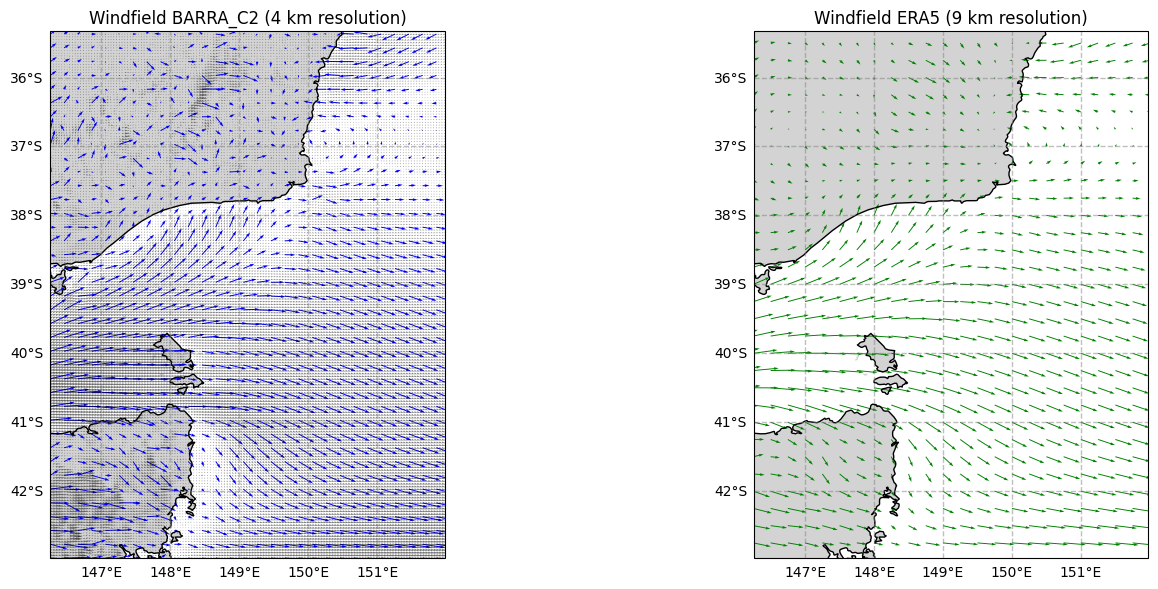

In [ ]:
step = 5  # nur jeden 5. Wert nehmen

# Korrekte Koordinatenzuweisung
lon_b = dB_uas_subset.lon
lat_b = dB_uas_subset.lat
lon_e = dE_subset.longitude
lat_e = dE_subset.latitude

# Mittelwerte der Winde
u_b_mean = dB_uas_subset.uas.mean(dim='time').values
v_b_mean = dB_vas_subset.vas.mean(dim='time').values

u_e_mean = dE_subset.u10.mean(dim='valid_time').values
v_e_mean = dE_subset.v10.mean(dim='valid_time').values

# 2D-Gitter für Pfeile
lon2d_b, lat2d_b = np.meshgrid(lon_b.values, lat_b.values)

lon2d_e, lat2d_e = np.meshgrid(lon_e.values, lat_e.values)

# Plot erstellen mit Kartenprojektion
fig, axs = plt.subplots(1, 2, figsize=(16, 6),
                        subplot_kw={'projection': ccrs.PlateCarree()})

# Funktion für Achsenbeschriftungen und Gridlines
def setup_map(ax, lon, lat):
    # Setze Gitterlinien mit Labels
    gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(),
                      linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 10}
    gl.ylabel_style = {'size': 10}


# dB Plot
axs[0].set_title('Windfield BARRA_C2 (4 km resolution)')
axs[0].coastlines()
axs[0].add_feature(cfeature.BORDERS, linestyle=':')
axs[0].add_feature(cfeature.LAND, facecolor='lightgray')
axs[0].quiver(lon2d_b[::step, ::step], lat2d_b[::step, ::step], u_b_mean[::step, ::step], v_b_mean[::step, ::step], scale=44, color="blue", transform=ccrs.PlateCarree())
axs[0].quiver(lon2d_b, lat2d_b, u_b_mean, v_b_mean, scale=250, alpha=0.5, transform=ccrs.PlateCarree())
axs[0].set_extent([
    float(lon_b.min().values), float(lon_b.max().values),
    float(lat_b.min().values), float(lat_b.max().values)
], crs=ccrs.PlateCarree())
setup_map(axs[0], lon_b, lat_b)

# dE Plot
axs[1].set_title('Windfield ERA5 (9 km resolution)')
axs[1].coastlines()
axs[1].add_feature(cfeature.BORDERS, linestyle=':')
axs[1].add_feature(cfeature.LAND, facecolor='lightgray')
axs[1].quiver(lon2d_e, lat2d_e, u_e_mean, v_e_mean, scale=44, color="green", transform=ccrs.PlateCarree())
axs[1].set_extent([
    float(lon_b.min().values), float(lon_b.max().values),
    float(lat_b.min().values), float(lat_b.max().values)
], crs=ccrs.PlateCarree())
setup_map(axs[1], lon_b, lat_b)

plt.tight_layout()
plt.show()


# Frequenz Histogramm


In [ ]:
# Funktion zur Berechnung von Windgeschwindigkeit und Richtung
def calc_wind_speed_dir(u, v):
    speed = np.sqrt(u**2 + v**2)
    # Windrichtung in Grad, 0° = Nord, im Uhrzeigersinn
    direction = (270 - np.degrees(np.arctan2(v, u))) % 360
    return speed, direction

# Barra
u_b = dB_uas_subset.uas.values.reshape(-1)  # Zeit x Raum → flach
v_b = dB_vas_subset.vas.values.reshape(-1)
speed_b, dir_b = calc_wind_speed_dir(u_b, v_b)

# ERA5
u_e = dE_subset.u10.values.reshape(-1)
v_e = dE_subset.v10.values.reshape(-1)
speed_e, dir_e = calc_wind_speed_dir(u_e, v_e)


NameError: name 'dB_uas_subset' is not defined